# Tutoriel pour **InfluxDB**

Bienvenue sur ce tutoriel ! Vous allez découvrir les principales fonctionnalitées de InfluxDB, une base de donnée non relationnelle orientée séries temporelles.
Elle peut être utilisée dans de nombreux domaines, en stockant par exemple :
    - les données des capteurs industriels,
    - les métriques de performance des serveurs,
    - les mesures des précipitations,
    - le cours en bourse.

## 🔎 Comment se présente la base de donnée ?

L'équivalent d'une occurance est un *point* qui est composé d'un *timestamp*, *measurement*, *tag keys*, *tag values* et *field key*.
Un groupe de points avec les mêmes mesurements, tags et fields sont appelées des séries temporelles (*time series*)

Les données sont organisées dans des *buckets*. Chaque bucket peut contenir plusieurs mesures (*mesurements*)  différentes.
Une mesure contiennent un timestamp et plusieurs *tags* et *fields*.
Les tags sont des paires clef-valeur dont les valeurs ne changent pas souvent. Ils sont indexés donc ils permettents d'organiser rapidement les données. Par exemple, cela peut être le lieu d'une expérience fixe, ou le nom de l'appareillage.
Les fields sont des paires clef-valeurs qui changent au cours du temps. Ils ne sont pas indexées. Par exemple, cela peut être la température ou la pression mesurée.



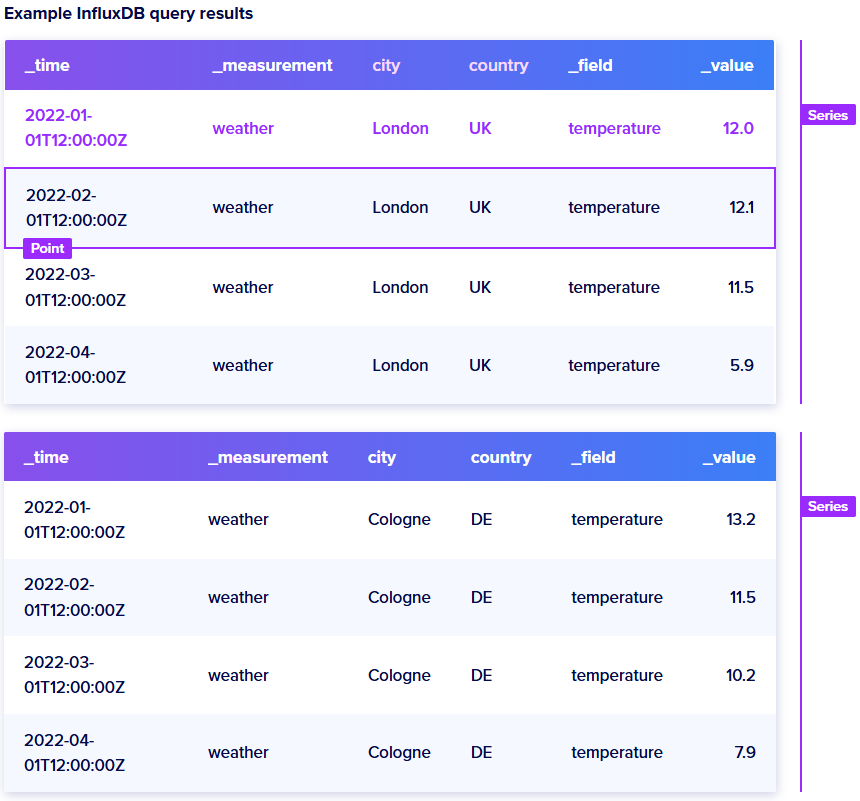

*Source: https://docs.influxdata.com*

In [1]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

In [2]:
# Paramètres de connexion
url = "http://influxdb:8086"
token = "my-secret-token"
org = "my-org"
bucket = "my-bucket"

In [3]:
# Création du client
client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

print("✅ Connexion réussie à InfluxDB!")

✅ Connexion réussie à InfluxDB!


In [4]:
# Population de la base de données
# Chemin du fichier contenant les données
FILENAME = "data/migration.txt"
print("Population de la base de données avec les données du fichier...", FILENAME)
with open(FILENAME, "r") as file:
    for line in file:
        write_api.write(bucket=bucket, org=org, record=line)
print("Population terminée!")


Population de la base de données avec les données du fichier... data/migration.txt


FileNotFoundError: [Errno 2] No such file or directory: 'data/migration.txt'

### 📊 Insertion de Données
Nous allons insérer une mesure simple (ex: température d'un capteur).


In [5]:
data = "temperature,sensor_id=1 value=22.5"
write_api.write(bucket=bucket, org=org, record=data)
print("✅ Donnée insérée avec succès!")

✅ Donnée insérée avec succès!


Commençons par examiner une line protocol element !

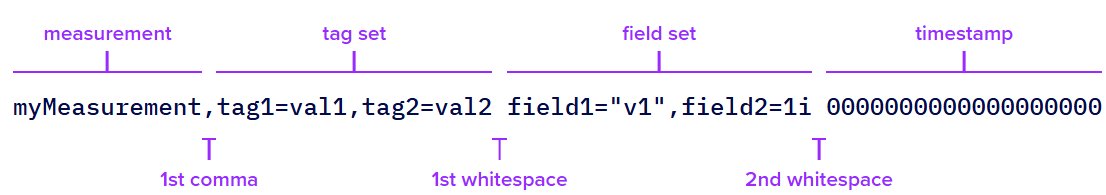

*Source: https://docs.influxdata.com*

A noter :
- il y a des virgules après le mesurement, pour séparer les tags entre eux, et pour séparer les fields entre eux;
- il y a un espace pour séparer les tags des fields, ainsi que les fields et le timestamp;
- les lines sont séparés entre elles par \n;
- si un des attribut à un espace dans son nom, on peut utiliser \ 
    ex: h`ome,room=Kitchen temp=21.0,hum=35.9,co=0i 1641024000
        home,room=Living\ Room temp=21.4,hum=35.9,co=0i 1641027600
``

Pour ce tutoriel, nous utilisons un dataset étudiant la qualité de l'air. Voici un line protocol element :

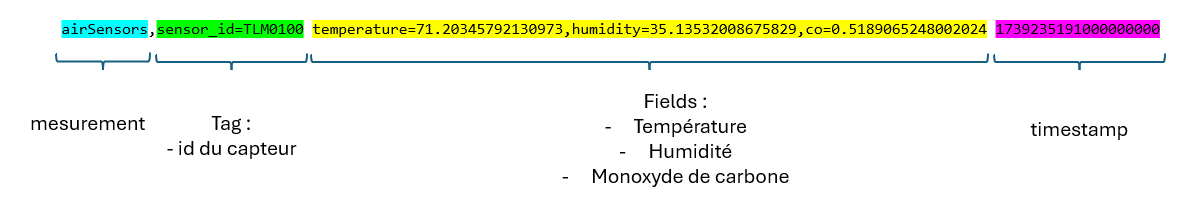

Pour ajouter une ou plusieurs *lines protocol*, on utilise `influx write` :
`

In [14]:
# Création d'une nouvelle mesure
data = "airSensors,sensor_id=TLM0100 temperature=71.20345792130973,humidity=35.13532008675829,co=0.5189065248002024 1739235191"
# Ajout de la mesure dans notre bucket
write_api.write(bucket=bucket, org=org, record=data)
print("✅ Donnée insérée avec succès!")


✅ Donnée insérée avec succès!


Nous venons donc d'ajouter la donnée que pour le timestamp 1739235191 : le capteur TLM0100 a mesuré une température de 71.20345792130973 °F, une humidité de 35.13532008675829 % et un densité de CO de 0.5189065248002024.
Nous allons maintenant visualiser pour vérifier si notre ajout a bien été effectué et que l'on peut voir les trois valeurs (co, humidity et temperature).

In [17]:
query = f'''
from(bucket: "{bucket}")
  |> range(start: 1739235190 , stop: 1739235192)
  |> filter(fn: (r) => r._measurement == "airSensors")
'''

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 2, 11, 0, 53, 10, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 2, 11, 0, 53, 12, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 2, 11, 0, 53, 11, tzinfo=datetime.timezone.utc), '_value': 0.5189065248002024, '_field': 'co', '_measurement': 'airSensors', 'sensor_id': 'TLM0100'}
📌 {'result': '_result', 'table': 1, '_start': datetime.datetime(2025, 2, 11, 0, 53, 10, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 2, 11, 0, 53, 12, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 2, 11, 0, 53, 11, tzinfo=datetime.timezone.utc), '_value': 35.13532008675829, '_field': 'humidity', '_measurement': 'airSensors', 'sensor_id': 'TLM0100'}
📌 {'result': '_result', 'table': 2, '_start': datetime.datetime(2025, 2, 11, 0, 53, 10, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 2, 11, 0, 53, 12, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2

Pour plus de précision :
- -b, --bucket ou --bucket-id permet de préciser le bucket concerné;
- -p, --precision permet de donner la precision du timestamp (s pour les secondes, m pour les minutes,...).

#### ❓ Rajoutez les mesures suivantes :
 - pour le timestamp 1839241791 : le capteur TLM0103 a mesuré une température de 74.56597046148916 °F, une humidité de 34.48544050518988 % et un densité de CO de 0.12410174546713217
 - pour le timestamp 1839241792 : le capteur TLM0202 a mesuré une température de 71.24597046148916 °F, une humidité de 33.71944373469555 % et un densité de CO de 0.6329052625629839

Executez le script suivant pour vérifier que votre ajout à fonctionné. Vous deviriez avoir :

In [ ]:
query=f'''
'''

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")

### 📖 Lecture des Données
Nous allons récupérer les données insérées à l'aide d'une requête.


In [25]:
query = f"""
from(bucket: "{bucket}")
|> range(start: -1h)
"""

result = query_api.query(org=org, query=query)

# Affichage des résultats
for table in result:
  for record in table.records:
      print(f"📌 {record.values}")

print("✅ Requête exécutée avec succès!")


📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 2, 18, 13, 5, 41, 702135, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 2, 18, 14, 5, 41, 702135, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 2, 18, 13, 23, 42, 465555, tzinfo=datetime.timezone.utc), '_value': 22.5, '_field': 'value', '_measurement': 'temperature', 'sensor_id': '1'}
📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 2, 18, 13, 5, 41, 702135, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 2, 18, 14, 5, 41, 702135, tzinfo=datetime.timezone.utc), '_time': datetime.datetime(2025, 2, 18, 13, 33, 33, 35821, tzinfo=datetime.timezone.utc), '_value': 22.5, '_field': 'value', '_measurement': 'temperature', 'sensor_id': '1'}
📌 {'result': '_result', 'table': 0, '_start': datetime.datetime(2025, 2, 18, 13, 5, 41, 702135, tzinfo=datetime.timezone.utc), '_stop': datetime.datetime(2025, 2, 18, 14, 5, 41, 702135, tzinfo=datetime.timezone.utc), 

### Process Data

In [ ]:
query = """
from(bucket: "{bucket}")
|> range(start: -1h)
|> filter(fn: (r) => r._measurement == "airSensors")
|> filter(fn: (r) => r._field == "temperature")
|> map(fn: (r) => ({ 
    _time: r._time, 
    _measurement: r._measurement, 
    _field: "temp_celsius", 
    _value: (r._value - 32.0) * 5.0 / 9.0 
}))"""

result = query_api.query(org=org, query=query)


In [ ]:
query = """
from(bucket: "bucket")
|> range(start: -1h)
|> filter(fn: (r) => r._measurement == "airSensors")
|> filter(fn: (r) => r._field == "co")
|> map(fn: (r) => ({r with state: if r._value < 2 then "ok" else "warning"}))""" 

result = query_api.query(org=org, query=query)

In [ ]:
query = """
from(bucket: "bucket")
|> range(start: -1h)
|> filter(fn: (r) => r._measurement == "airSensors")
|> filter(fn: (r) => r._field == "temp")
|> group(columns: ["sensor_id"])""" 

result = query_api.query(org=org, query=query)

In [ ]:
query = """from(bucket: "bucket")
|> range(start: -1h)
|> filter(fn: (r) => r._measurement == "airSensors")
|> filter(fn: (r) => r._field == "temp")
|> group(columns: ["sensor_id"])
|> mean()"""

result = query_api.query(org=org, query=query)

In [ ]:
query = """from(bucket: "bucket")
|> range(start: 2022-01-01T14:00:00Z, stop: 2022-01-01T20:00:01Z)
|> filter(fn: (r) => r._measurement == "airSensors")
|> filter(fn: (r) => r._field == "co" or r._field == "hum" or r._field == "temp")
|> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")"""

result = query_api.query(org=org, query=query)

### ❌ Fermeture de la connexion
Toujours fermer la connexion après utilisation pour libérer les ressources.


In [ ]:
client.close()
print("✅ Connexion fermée.")

✅ Connexion fermée.
